In [1]:
## make plots inline - for ipython notebooks
%matplotlib inline

from numpy import linspace, sqrt, array, pi, cos, sin, dot, exp, sinh, log, log10, cosh, sinh
from numpy import atleast_1d, zeros, where, zeros_like
import numpy as np
from scipy.misc import derivative
import matplotlib.pyplot as plt
from pylab import loadtxt
from numpy.linalg import norm as norm
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from scipy import interpolate
import time
import math
import scipy.special as sp
from scipy import integrate
import matplotlib.ticker as ticker

import matplotlib
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
# Make use of TeX\ufeff
# rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})


# Change all fonts to 'Computer Modern'
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=10)
rc('xtick', labelsize=16)
rc('ytick.major', size=5, pad=10)
rc('ytick', labelsize=16)

plt.rcParams['figure.dpi'] = 125
plt.rcParams['savefig.dpi'] = 300

pcolors=['SteelBlue','Indigo','FireBrick','Coral','Tan','OliveDrab']

In [2]:
# running CLASS once to get various background quantities
k = 1.e-4  # 1/Mpc
common_settings = {'output':'mPk',
                   'k_output_values':k,
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.1201075,
                   'A_s':2.100549e-09 ,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   'YHe':0.2454,
                   'compute damping scale':'yes',
                   'gauge':'newtonian'}  

M = Class()
M.set(common_settings)
M.compute()

derived = M.get_current_derived_parameters(['tau_rec','conformal_age','z_rec'])
thermo = M.get_thermodynamics()

z_rec = derived['z_rec']
tau_rec=derived['tau_rec']
tau_0=derived['conformal_age']
tau_0_minus_tau_rec_Mpc = (tau_0-tau_rec)
tau_reio=4255.316282

exp_kappa=thermo['exp(-kappa)']
tau = thermo['conf. time [Mpc]']
g = thermo['g [Mpc^-1]']

exp_kappa_func=interpolate.interp1d(tau,exp_kappa,kind='cubic')
g_func=interpolate.interp1d(tau,g,kind='cubic')

In [3]:
k_list=np.linspace(1.e-4,5.e-1,300) # change based on what k-space resolution you need, max=1000

#np.linspace(1.e-4,1.e-1,1000)
tau_list1=np.linspace(200,tau_rec,100) # change based on what tau-space resolution you need, max=100
tau_list2=np.linspace(tau_rec+1,1.e+3,300) # change based on what tau-space resolution you need, max=700
tau_list=np.concatenate((tau_list1,tau_list2))

tau_diff_list=tau_list[1:len(tau_list)]-tau_list[0:len(tau_list)-1] # time difference array needed to compute the Riemann sum

In [4]:
# running CLASS for each k and storing phi, psi, theta etc. outputs in arrays

phi_list=[]
psi_list=[]
theta_list=[]

phi_prime_list=[]
psi_prime_list=[]

for k in k_list:
    M.empty()
    common_settings = {'output':'mPk',
                   'k_output_values':k,
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.1201075,
                   'A_s':2.100549e-09 ,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   'YHe':0.2454,
                   'compute damping scale':'yes', 
                   'gauge':'newtonian'} 
    M.set(common_settings)
    M.compute()
    all_k = M.get_perturbations()  
    one_k = all_k['scalar'][0]      
    tau_pert = one_k['tau [Mpc]']
    Theta0 = 0.25*one_k['delta_g']
    phi = one_k['phi']
    psi = one_k['psi']
    theta_b = one_k['theta_b']
    a = one_k['a']
    phi_func=interpolate.interp1d(tau_pert,phi,kind='cubic')
    psi_func=interpolate.interp1d(tau_pert,psi,kind='cubic')
    theta0_func=interpolate.interp1d(tau_pert,Theta0,kind='cubic')   
    
    phi_list.append(np.append(k,phi_func(tau_list))) # first index is the k value
    psi_list.append(np.append(k,psi_func(tau_list)))
    theta_list.append(np.append(k,theta0_func(tau_list)))    
    phi_prime_list.append(np.append(k,derivative(phi_func,tau_list,dx=0.1)))
    psi_prime_list.append(np.append(k,derivative(psi_func,tau_list,dx=0.1)))
    

In [5]:
## 99th entry gives tau_rec
tau_list[99]-tau_rec

0.0

In [6]:
tau_diff_list=tau_list[1:len(tau_list)]-tau_list[0:len(tau_list)-1] # time difference array needed to compute the Riemann sum
k_diff_list=k_list[1:len(k_list)]-k_list[0:len(k_list)-1] # k difference array needed to compute Riemann sum

def func(x): # defines the curvature perturbation in momentum space
    return sp.sici(x)[0]-np.sin(x) #sici returns {si(x), ci(x)} as tuples

phidot=59**2
g=1
prefac=-g/phidot*(4*np.pi)/(2*np.pi)**3*2.7*1.e+6

### ISW Transfer function, need to evaluate only once

In [7]:
# ISW transfer function, f_ISW(k,l) in the draft

f_ISW = np.zeros_like(k_list)

for ell in np.arange(1,600):
    sum_over_k = []
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time=exp_kappa_func(tau_list)*(psi_prime_list[n][1:len(tau_list)+1]+phi_prime_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list)) # the integrand for time integral
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list) # time integral done using Riemann sum
        sum_over_k.append(integral_time)
    f_ISW = np.vstack((f_ISW, sum_over_k))
        

### SW Transfer function, need to evaluate only once

In [8]:
# SW transfer function, f_SW(k,l) in the draft

f_SW = np.zeros_like(k_list)

for ell in np.arange(1, 2000):
    sum_over_k_SW = [] 
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time_SW = (psi_list[n][99]+theta_list[n][99])*sp.spherical_jn(ell,k_val*(tau_0-tau_rec)) ## 99 implies evaluation at tau_rec
        sum_over_k_SW.append(integrand_time_SW)
    f_SW = np.vstack((f_SW, sum_over_k_SW))


### ISW for single eta_HS

In [9]:
# the full computation of ISW, with new tau_rec dependence, single etap and single eta_HS
eta_HS = tau_rec

etap=100


integrand_list=[]
ell_count=1
for ell in np.arange(1,600):
    sum_over_k=[]
    for n in range(len(k_list)): # loops over all k values for each ell
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val # the integrand for k integral
        sum_over_k.append(integrand_full) 
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum
    ell_count += 1

print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  

the ISW amplitude is 2.23584696973667


### SW for single eta_HS

In [10]:
# the full computation of SW piece, code structure same as ISW piece, new tau_rec dependence, single etap
eta_HS = tau_rec

etap=100


integrand_list=[]
ell_count=1
for ell in np.arange(1,2000):
    sum_over_k=[]
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0]        
        integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
        sum_over_k.append(integrand_full)
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
    ell_count +=1

print('the SW amplitude is',np.sum(integrand_list))

the SW amplitude is 7.818788269392195


### Central temperature scan for different eta_HS, ISW piece

In [11]:
tau_rec

280.62745874925827

In [12]:
etap=100


ISW_central_list=[]

for eta_HS in np.linspace(tau_rec-etap, tau_rec+etap, 50):
    integrand_list=[]
    ell_count=1
    for ell in np.arange(1,600):
        sum_over_k=[]
        for n in range(len(k_list)): # loops over all k values for each ell
            k_val=psi_prime_list[n][0] # first value gives the k
            integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val # the integrand for k integral
            sum_over_k.append(integrand_full) 
        integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum
        ell_count += 1
    print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  
    ISW_central_list.append(np.sum(integrand_list))

the ISW amplitude is 0.12929005359192955
the ISW amplitude is 0.18602632925875823
the ISW amplitude is 0.24636421288678356
the ISW amplitude is 0.3101335046766124
the ISW amplitude is 0.3771894157256799
the ISW amplitude is 0.4474088213360513
the ISW amplitude is 0.5206820260638362
the ISW amplitude is 0.5969037808491731
the ISW amplitude is 0.6759643007799475
the ISW amplitude is 0.7577403042861046
the ISW amplitude is 0.8420887807976623
the ISW amplitude is 0.9288452916194738
the ISW amplitude is 1.0178283209941488
the ISW amplitude is 1.1088500261975853
the ISW amplitude is 1.2017279398452505
the ISW amplitude is 1.2962911954924825
the ISW amplitude is 1.392378824903996
the ISW amplitude is 1.4898285664585442
the ISW amplitude is 1.5884578188066327
the ISW amplitude is 1.6880423826612256
the ISW amplitude is 1.7882955131556937
the ISW amplitude is 1.8888501211434041
the ISW amplitude is 1.9892509126026732
the ISW amplitude is 2.0889566363720675
the ISW amplitude is 2.187350166703214

### Central temperature scan for different eta_HS, SW piece

In [13]:
etap=100

SW_central_list=[]

for eta_HS in np.linspace(tau_rec-etap, tau_rec+etap, 50):
    integrand_list=[]
    ell_count=1
    for ell in np.arange(1,2000):
        sum_over_k=[]
        for n in range(len(k_list)):
            k_val=psi_prime_list[n][0]        
            integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
            sum_over_k.append(integrand_full)
        integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
        ell_count +=1
    print('the SW amplitude is',np.sum(integrand_list))
    SW_central_list.append(np.sum(integrand_list))

the SW amplitude is 6.199675515600964
the SW amplitude is 6.158575964223498
the SW amplitude is 6.084467069117766
the SW amplitude is 5.958172721802426
the SW amplitude is 5.774540851631006
the SW amplitude is 5.536479533926986
the SW amplitude is 5.245281228284194
the SW amplitude is 4.900669789977809
the SW amplitude is 4.499967595319777
the SW amplitude is 4.038844814713165
the SW amplitude is 3.5228290753845686
the SW amplitude is 2.9838680073786827
the SW amplitude is 2.494889136228543
the SW amplitude is 2.165747190127377
the SW amplitude is 2.10049238966935
the SW amplitude is 2.3420643958071254
the SW amplitude is 2.8544073792508358
the SW amplitude is 3.547583171362973
the SW amplitude is 4.321119382604847
the SW amplitude is 5.100515949420194
the SW amplitude is 5.84147288182781
the SW amplitude is 6.512217467468999
the SW amplitude is 7.086306759804062
the SW amplitude is 7.530936256714634
the SW amplitude is 7.784933748827798
the SW amplitude is 7.785192306442054
the SW amp

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


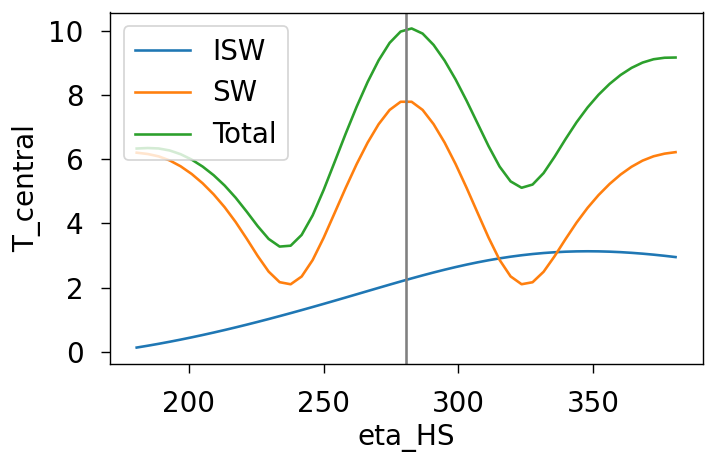

In [14]:
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), ISW_central_list, label='ISW')
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), SW_central_list, label='SW')
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), np.array(SW_central_list)+np.array(ISW_central_list), label='Total')
plt.xlabel('eta_HS')
plt.ylabel('T_central')
plt.legend()
plt.axvline(x=tau_rec, color='gray')
plt.tight_layout()
plt.savefig('eta100_central_temp.pdf')

In [25]:
np.logspace(-4.0, -1.0, num=1)

array([0.0001])

### Temperature angular profilescan for different \eta_HS, SW piece

In [15]:
etap=100

eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 50)
ang_arr = np.logspace(-3.7, -0.7, num=100)

SW_angle_arr=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    print(eta_HS)
    SW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,2000): 
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        SW_angle_temp.append(np.sum(integrand_list))
        
    SW_angle_arr = np.vstack((SW_angle_arr, SW_angle_temp))
np.savetxt('SW_stack_eta100.txt', SW_angle_arr)

180.62745874925827
184.7090914023195
188.7907240553807
192.87235670844194
196.95398936150318
201.03562201456438
205.11725466762562
209.19888732068685
213.28051997374806
217.3621526268093
221.4437852798705
225.52541793293173
229.60705058599297
233.68868323905417
237.7703158921154
241.85194854517664
245.93358119823785
250.01521385129908
254.09684650436031
258.1784791574215
262.2601118104827
266.341744463544
270.4233771166052
274.50500976966646
278.58664242272766
282.66827507578887
286.7499077288501
290.83154038191134
294.91317303497254
298.9948056880338
303.076438341095
307.1580709941562
311.2397036472174
315.3213363002787
319.4029689533399
323.48460160640116
327.56623425946236
331.64786691252357
335.7294995655848
339.81113221864604
343.89276487170724
347.9743975247685
352.0560301778297
356.1376628308909
360.2192954839521
364.3009281370134
368.3825607900746
372.46419344313585
376.54582609619706
380.62745874925827


In [36]:
#np.savetxt('SW_stack_eta100_bkup.txt', SW_angle_arr)

In [42]:
SW_angle_arr

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.19807466e+00, 6.19784044e+00, 6.19757291e+00, ...,
        4.12495380e-04, 4.17120294e-04, 2.68248993e-04],
       [6.15447606e+00, 6.15387178e+00, 6.15318011e+00, ...,
        3.44944379e-04, 3.58956813e-04, 2.30856499e-04],
       ...,
       [6.08149705e+00, 6.08067634e+00, 6.07973647e+00, ...,
        7.15432256e-05, 8.39894052e-05, 2.02266576e-04],
       [6.16470332e+00, 6.16404567e+00, 6.16329279e+00, ...,
        1.74583278e-04, 1.71995750e-04, 2.86204054e-04],
       [6.21364924e+00, 6.21332438e+00, 6.21295293e+00, ...,
        2.46496337e-04, 2.33427242e-04, 3.44952326e-04]])

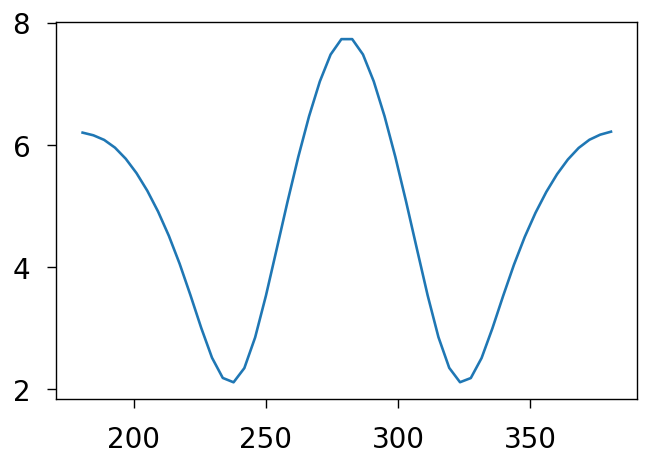

In [43]:
plt.plot(eta_HS_arr, SW_angle_arr.T[0][1:])

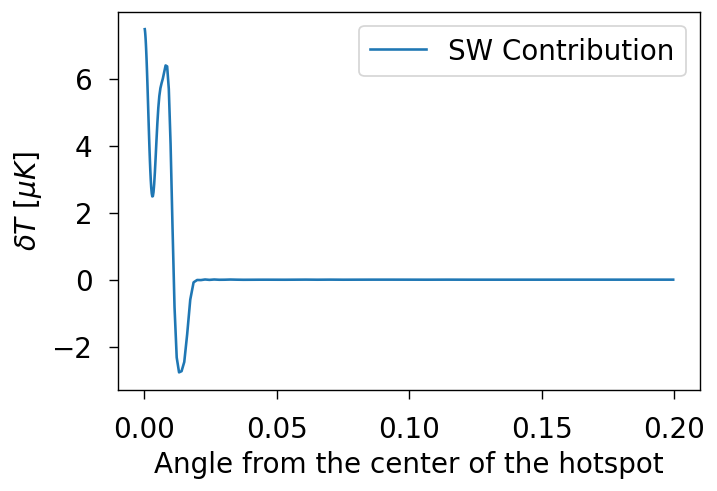

In [20]:
plt.plot(ang_arr, SW_angle_arr[24], label='SW Contribution')
#plt.xscale('log')
plt.xlabel('Angle from the center of the hotspot')
plt.ylabel('$\delta T~[\mu K]$')
plt.legend()

### Temperature angular profilescan for different \eta_HS, ISW piece

In [18]:
etap=100

eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 50)
ang_arr = np.logspace(-3.7, -0.7, num=100)

ISW_angle_arr=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    ISW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,600):
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        ISW_angle_temp.append(np.sum(integrand_list))
        
    ISW_angle_arr = np.vstack((ISW_angle_arr, ISW_angle_temp))

In [19]:
np.savetxt('ISW_stack_eta100.txt', ISW_angle_arr)

In [33]:
ISW_angle_arr = np.loadtxt('../ISW_stack.txt')

In [40]:
ISW_angle_arr = np.loadtxt('ISW_stack_eta100_bkup.txt')

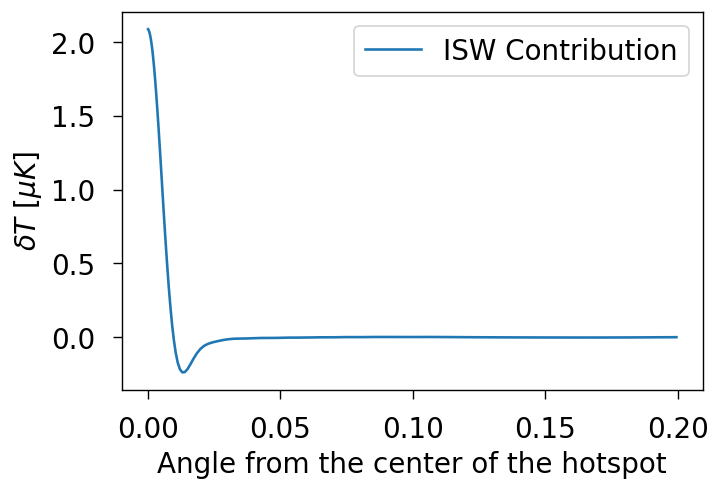

In [41]:
ang_arr = np.logspace(-3.7, -0.7, num=100)
plt.plot(ang_arr, ISW_angle_arr[24], label='ISW Contribution')
#plt.xscale('log')
plt.xlabel('Angle from the center of the hotspot')
plt.ylabel('$\delta T~[\mu K]$')
plt.legend()

In [28]:
eta_HS_arr[24]

277.3621526268093

# Old

In [52]:
etap=160
eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 5)
ang_arr = np.linspace(0.07, 0.2, num=10)

ISW_angle_arr_n=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    ISW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,600):
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        ISW_angle_temp.append(np.sum(integrand_list))
        
    ISW_angle_arr_n = np.vstack((ISW_angle_arr_n, ISW_angle_temp))

In [45]:
# the full computation of ISW, with new tau_rec dependence, single etap and single eta_HS
eta_HS = tau_rec

etap=160
integrand_list=[]
for ell in np.arange(20,600):
    sum_over_k=[]
    for n in range(len(k_list)): # loops over all k values for each ell
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time=exp_kappa_func(tau_list)*(psi_prime_list[n][1:len(tau_list)+1]+phi_prime_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list)) # the integrand for time integral
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list) # time integral done using Riemann sum
        
        integrand_full=prefac*integral_time*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-tau_rec))*(2*ell+1)/k_val # the integrand for k integral
        sum_over_k.append(integrand_full) 
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum

print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  

the ISW amplitude is 5.611001349298974


In [11]:
# the full computation of SW piece, code structure same as ISW piece, new tau_rec dependence, single etap
etap=160
integrand_list=[]
for ell in np.arange(20,2000):
    sum_over_k=[]
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0]
        integrand_time=g_func(tau_list)*(psi_list[n][1:len(tau_list)+1]+theta_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list))
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list)
        
        integrand_full=prefac*integral_time*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-tau_rec))*(2*ell+1)/k_val
        sum_over_k.append(integrand_full)
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))

print('the SW amplitude is',np.sum(integrand_list))    

the SW amplitude is 28.663737220837334
